In [3]:
import pandas as pd
import numpy as np
import csv

In [4]:
limit=5000

In [5]:
def load_data():
    gnrl_cols_interest=['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
    'Physician_Profile_ID',
    'Physician_First_Name',
    'Physician_Middle_Name',
    'Physician_Last_Name',
    'Physician_Specialty',
    'Physician_Primary_Type',
    'Recipient_City',
    'Recipient_Province',
    'Recipient_State',
    'Recipient_Zip_Code',
    'Physician_Ownership_Indicator',
    'Program_Year',
    'Charity_Indicator',
    'Nature_of_Payment_or_Transfer_of_Value',                  
    'Record_ID',
    'Total_Amount_of_Payment_USDollars',
    'Number_of_Payments_Included_in_Total_Amount']
    general_payments=pd.read_csv('OP_DTL_GNRL_PGYR2013_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit).append(pd.read_csv('OP_DTL_GNRL_PGYR2014_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit)).append(pd.read_csv('OP_DTL_GNRL_PGYR2015_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit)).append(pd.read_csv('OP_DTL_GNRL_PGYR2016_P06302017.csv',usecols=gnrl_cols_interest,nrows=limit))
    general_payments = general_payments[np.isfinite(general_payments['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'])]
    general_payments = general_payments[np.isfinite(general_payments['Physician_Profile_ID'])]
    general_payments['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID']=general_payments['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].apply(int).apply(str)
    general_payments['Physician_Profile_ID']=general_payments['Physician_Profile_ID'].apply(int).apply(str)
    print(general_payments.shape)
    print(general_payments.Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID.nunique())
    print(general_payments.Physician_Profile_ID.nunique())
    return general_payments

In [6]:
def create_inputs(general_payments):
    grouped_payments_phys=general_payments.groupby(['Physician_Profile_ID','Program_Year'])['Total_Amount_of_Payment_USDollars','Number_of_Payments_Included_in_Total_Amount'].sum().reset_index()
    payment_phys=grouped_payments_phys.pivot(index='Physician_Profile_ID', columns='Program_Year', values='Total_Amount_of_Payment_USDollars').reset_index().replace(np.nan, 0, regex=True)
    num_payment_phys=grouped_payments_phys.pivot(index='Physician_Profile_ID', columns='Program_Year', values='Number_of_Payments_Included_in_Total_Amount').reset_index().replace(np.nan, 0, regex=True)
    phys_level=general_payments[['Physician_Profile_ID','Physician_Specialty','Physician_Primary_Type','Recipient_State']].drop_duplicates(subset='Physician_Profile_ID')
    phys_level=phys_level.join(phys_level.Physician_Specialty.str.split('|').str.join('|').str.get_dummies(),how='left',on='Physician_Profile_ID',rsuffix='_r')
    phys_level=phys_level.join(phys_level.Recipient_State.str.get_dummies(),how='left',on='Physician_Profile_ID',rsuffix='_r')
    phys_level=phys_level.join(phys_level.Physician_Primary_Type.str.get_dummies(),how='left',on='Physician_Profile_ID',rsuffix='_r')
    payment_phys['Physician_Profile_ID']=payment_phys['Physician_Profile_ID'].astype(str)
    num_payment_phys['Physician_Profile_ID']=num_payment_phys['Physician_Profile_ID'].astype(str)
    phys_level['Physician_Profile_ID']=phys_level['Physician_Profile_ID'].astype(str)
    phys_level=phys_level.merge(payment_phys.merge(num_payment_phys,how='left',on='Physician_Profile_ID'),how='left',on='Physician_Profile_ID').reset_index(drop=True)
    phys_level=phys_level.drop(['Physician_Specialty','Physician_Primary_Type','Recipient_State'], axis=1).replace(np.nan, 0, regex=True)
    return phys_level

In [7]:
def preprocess(data,pca_flag,numcomps):
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    X_data = data.iloc[:,1:].replace(np.nan, 0, regex=True).values
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1),copy=False)
    X_data = scaler.fit_transform(X_data)
    X_data_viz = TSNE(n_components=2).fit_transform(X_data)
    if pca_flag==1:
        X_data=TSNE(n_components=numcomps).fit_transform(X_data)   
        X_data_viz=X_data
    return X_data,X_data_viz

In [8]:
general_payments=load_data()
phys_level=create_inputs(general_payments)
X_phys,X_phys_viz = preprocess(phys_level,1,2)

(19925, 21)
56
11633


In [20]:
X=X_phys

from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = range(2,500)
sil_list=np.empty(len(range_n_clusters),)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    sil_list[n_clusters-2]=silhouette_avg
    print("Clusters: ", n_clusters,
          "Silhouette score:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)


Automatically created module for IPython interactive environment
Clusters:  2 Silhouette score: 0.29921734
Clusters:  3 Silhouette score: 0.32236242
Clusters:  4 Silhouette score: 0.30808023
Clusters:  5 Silhouette score: 0.3028031
Clusters:  6 Silhouette score: 0.31657436
Clusters:  7 Silhouette score: 0.3051009
Clusters:  8 Silhouette score: 0.29974136
Clusters:  9 Silhouette score: 0.2823176
Clusters:  10 Silhouette score: 0.2889671
Clusters:  11 Silhouette score: 0.2843663
Clusters:  12 Silhouette score: 0.30082157
Clusters:  13 Silhouette score: 0.30489805
Clusters:  14 Silhouette score: 0.30931163
Clusters:  15 Silhouette score: 0.307176
Clusters:  16 Silhouette score: 0.30545458
Clusters:  17 Silhouette score: 0.3082061
Clusters:  18 Silhouette score: 0.3101732
Clusters:  19 Silhouette score: 0.30467302
Clusters:  20 Silhouette score: 0.31318465
Clusters:  21 Silhouette score: 0.31725046
Clusters:  22 Silhouette score: 0.33036286
Clusters:  23 Silhouette score: 0.33346117
Cluste

Clusters:  192 Silhouette score: 0.58606815
Clusters:  193 Silhouette score: 0.5864024
Clusters:  194 Silhouette score: 0.5871975
Clusters:  195 Silhouette score: 0.58817136
Clusters:  196 Silhouette score: 0.5879165
Clusters:  197 Silhouette score: 0.5885249
Clusters:  198 Silhouette score: 0.5880028
Clusters:  199 Silhouette score: 0.58851504
Clusters:  200 Silhouette score: 0.58884156
Clusters:  201 Silhouette score: 0.58918685
Clusters:  202 Silhouette score: 0.58995116
Clusters:  203 Silhouette score: 0.59108204
Clusters:  204 Silhouette score: 0.59061575
Clusters:  205 Silhouette score: 0.5910783
Clusters:  206 Silhouette score: 0.592096
Clusters:  207 Silhouette score: 0.5923562
Clusters:  208 Silhouette score: 0.5928598
Clusters:  209 Silhouette score: 0.59420586
Clusters:  210 Silhouette score: 0.59514266
Clusters:  211 Silhouette score: 0.5957925
Clusters:  212 Silhouette score: 0.5963882
Clusters:  213 Silhouette score: 0.59801877
Clusters:  214 Silhouette score: 0.59911746


Clusters:  381 Silhouette score: 0.6275687
Clusters:  382 Silhouette score: 0.6277848
Clusters:  383 Silhouette score: 0.62796634
Clusters:  384 Silhouette score: 0.62784135
Clusters:  385 Silhouette score: 0.6277308
Clusters:  386 Silhouette score: 0.62829536
Clusters:  387 Silhouette score: 0.6286446
Clusters:  388 Silhouette score: 0.6286099
Clusters:  389 Silhouette score: 0.62864095
Clusters:  390 Silhouette score: 0.6287502
Clusters:  391 Silhouette score: 0.62915134
Clusters:  392 Silhouette score: 0.62906086
Clusters:  393 Silhouette score: 0.6290525
Clusters:  394 Silhouette score: 0.62841403
Clusters:  395 Silhouette score: 0.62822676
Clusters:  396 Silhouette score: 0.6287383
Clusters:  397 Silhouette score: 0.62888783
Clusters:  398 Silhouette score: 0.62901163
Clusters:  399 Silhouette score: 0.62857765
Clusters:  400 Silhouette score: 0.6284766
Clusters:  401 Silhouette score: 0.6292027
Clusters:  402 Silhouette score: 0.62894845
Clusters:  403 Silhouette score: 0.6292695

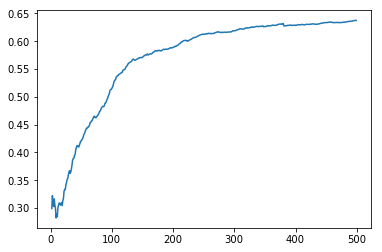

In [21]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# create some x data and some integers for the y axis
x = range_n_clusters
y = sil_list

# plot the data
ax.plot(x,y)


In [9]:
nclust=125
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X_phys, n_neighbors=30, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
phys_labels=pd.DataFrame()
agglo3= AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=nclust, connectivity=connectivity)
try:
    labels_agglo3=agglo3.fit_predict(X_phys)
    phys_labels['labels_agglo3']=labels_agglo3
except:
    pass

/Users/smh/anaconda/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 53 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


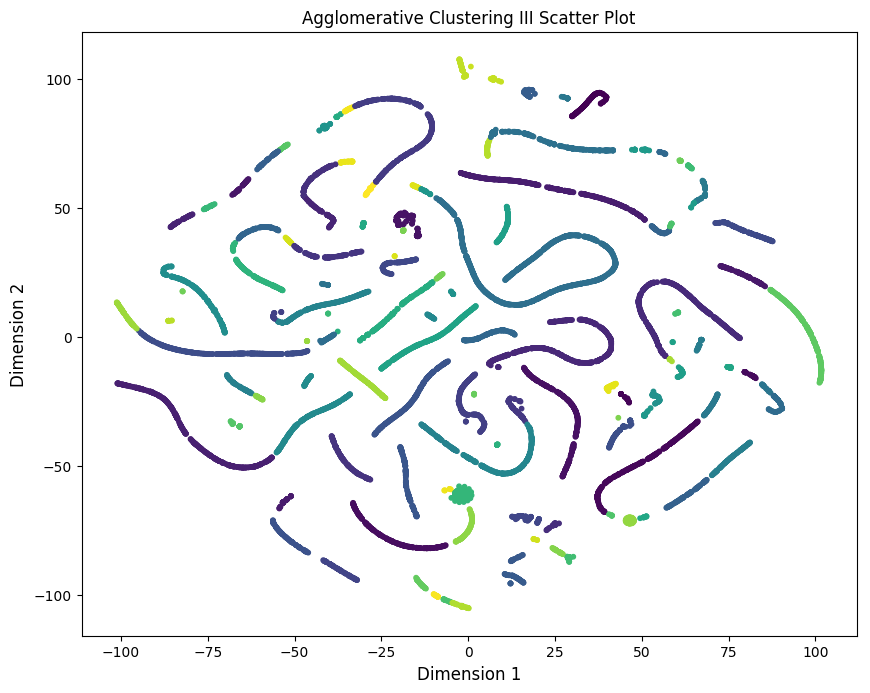

In [10]:
import matplotlib.pyplot as plt
phys_labels['Physician_Profile_ID']=phys_level.iloc[:,0]


plt.figure(figsize=(10, 8), dpi=100)
plt.title('Agglomerative Clustering Scatter Plot', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.scatter(X_phys_viz[:, 0], X_phys_viz[:, 1], c=phys_labels['labels_agglo3'],s=10, cmap='viridis');
plt.show()

In [11]:
general_payments_clus=general_payments.merge(phys_labels, left_on='Physician_Profile_ID', right_on='Physician_Profile_ID', how='left')

Algorithm: Agglomerative Clustering III


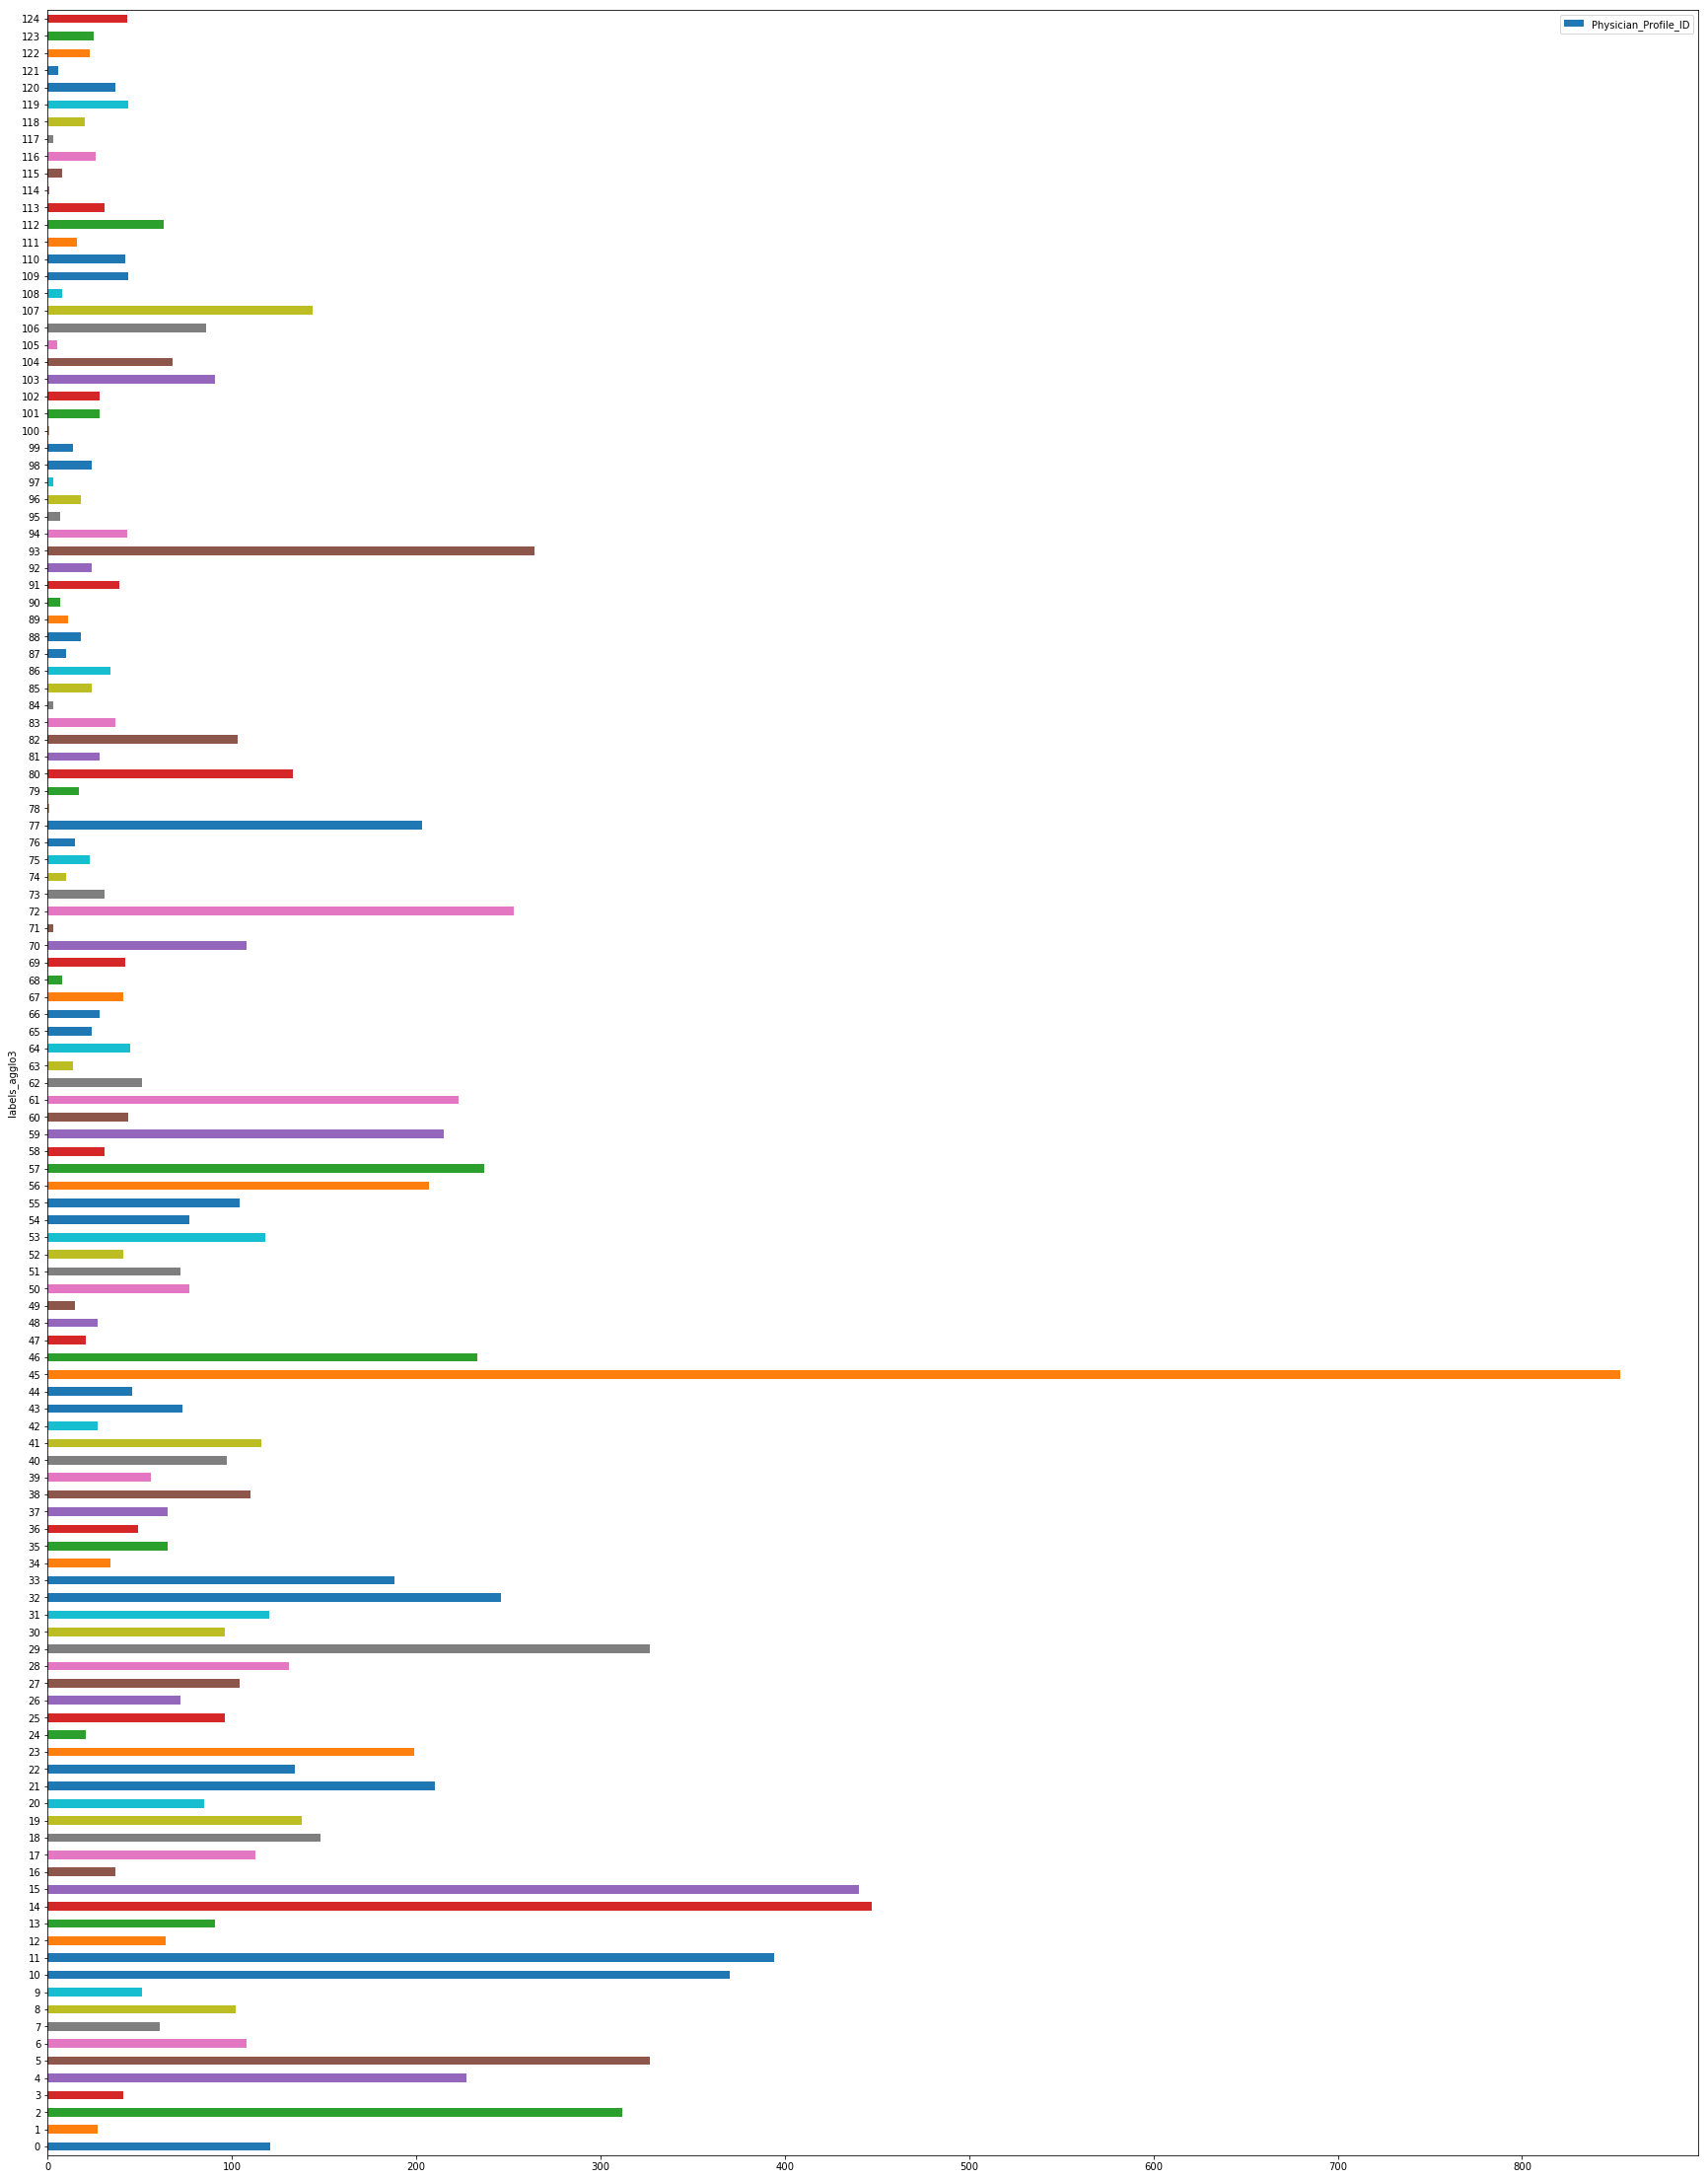

In [16]:
print("Algorithm: Agglomerative Clustering III")
%matplotlib inline
plt.figure(figsize=(30,40))
general_payments_clus.groupby('labels_agglo3')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)

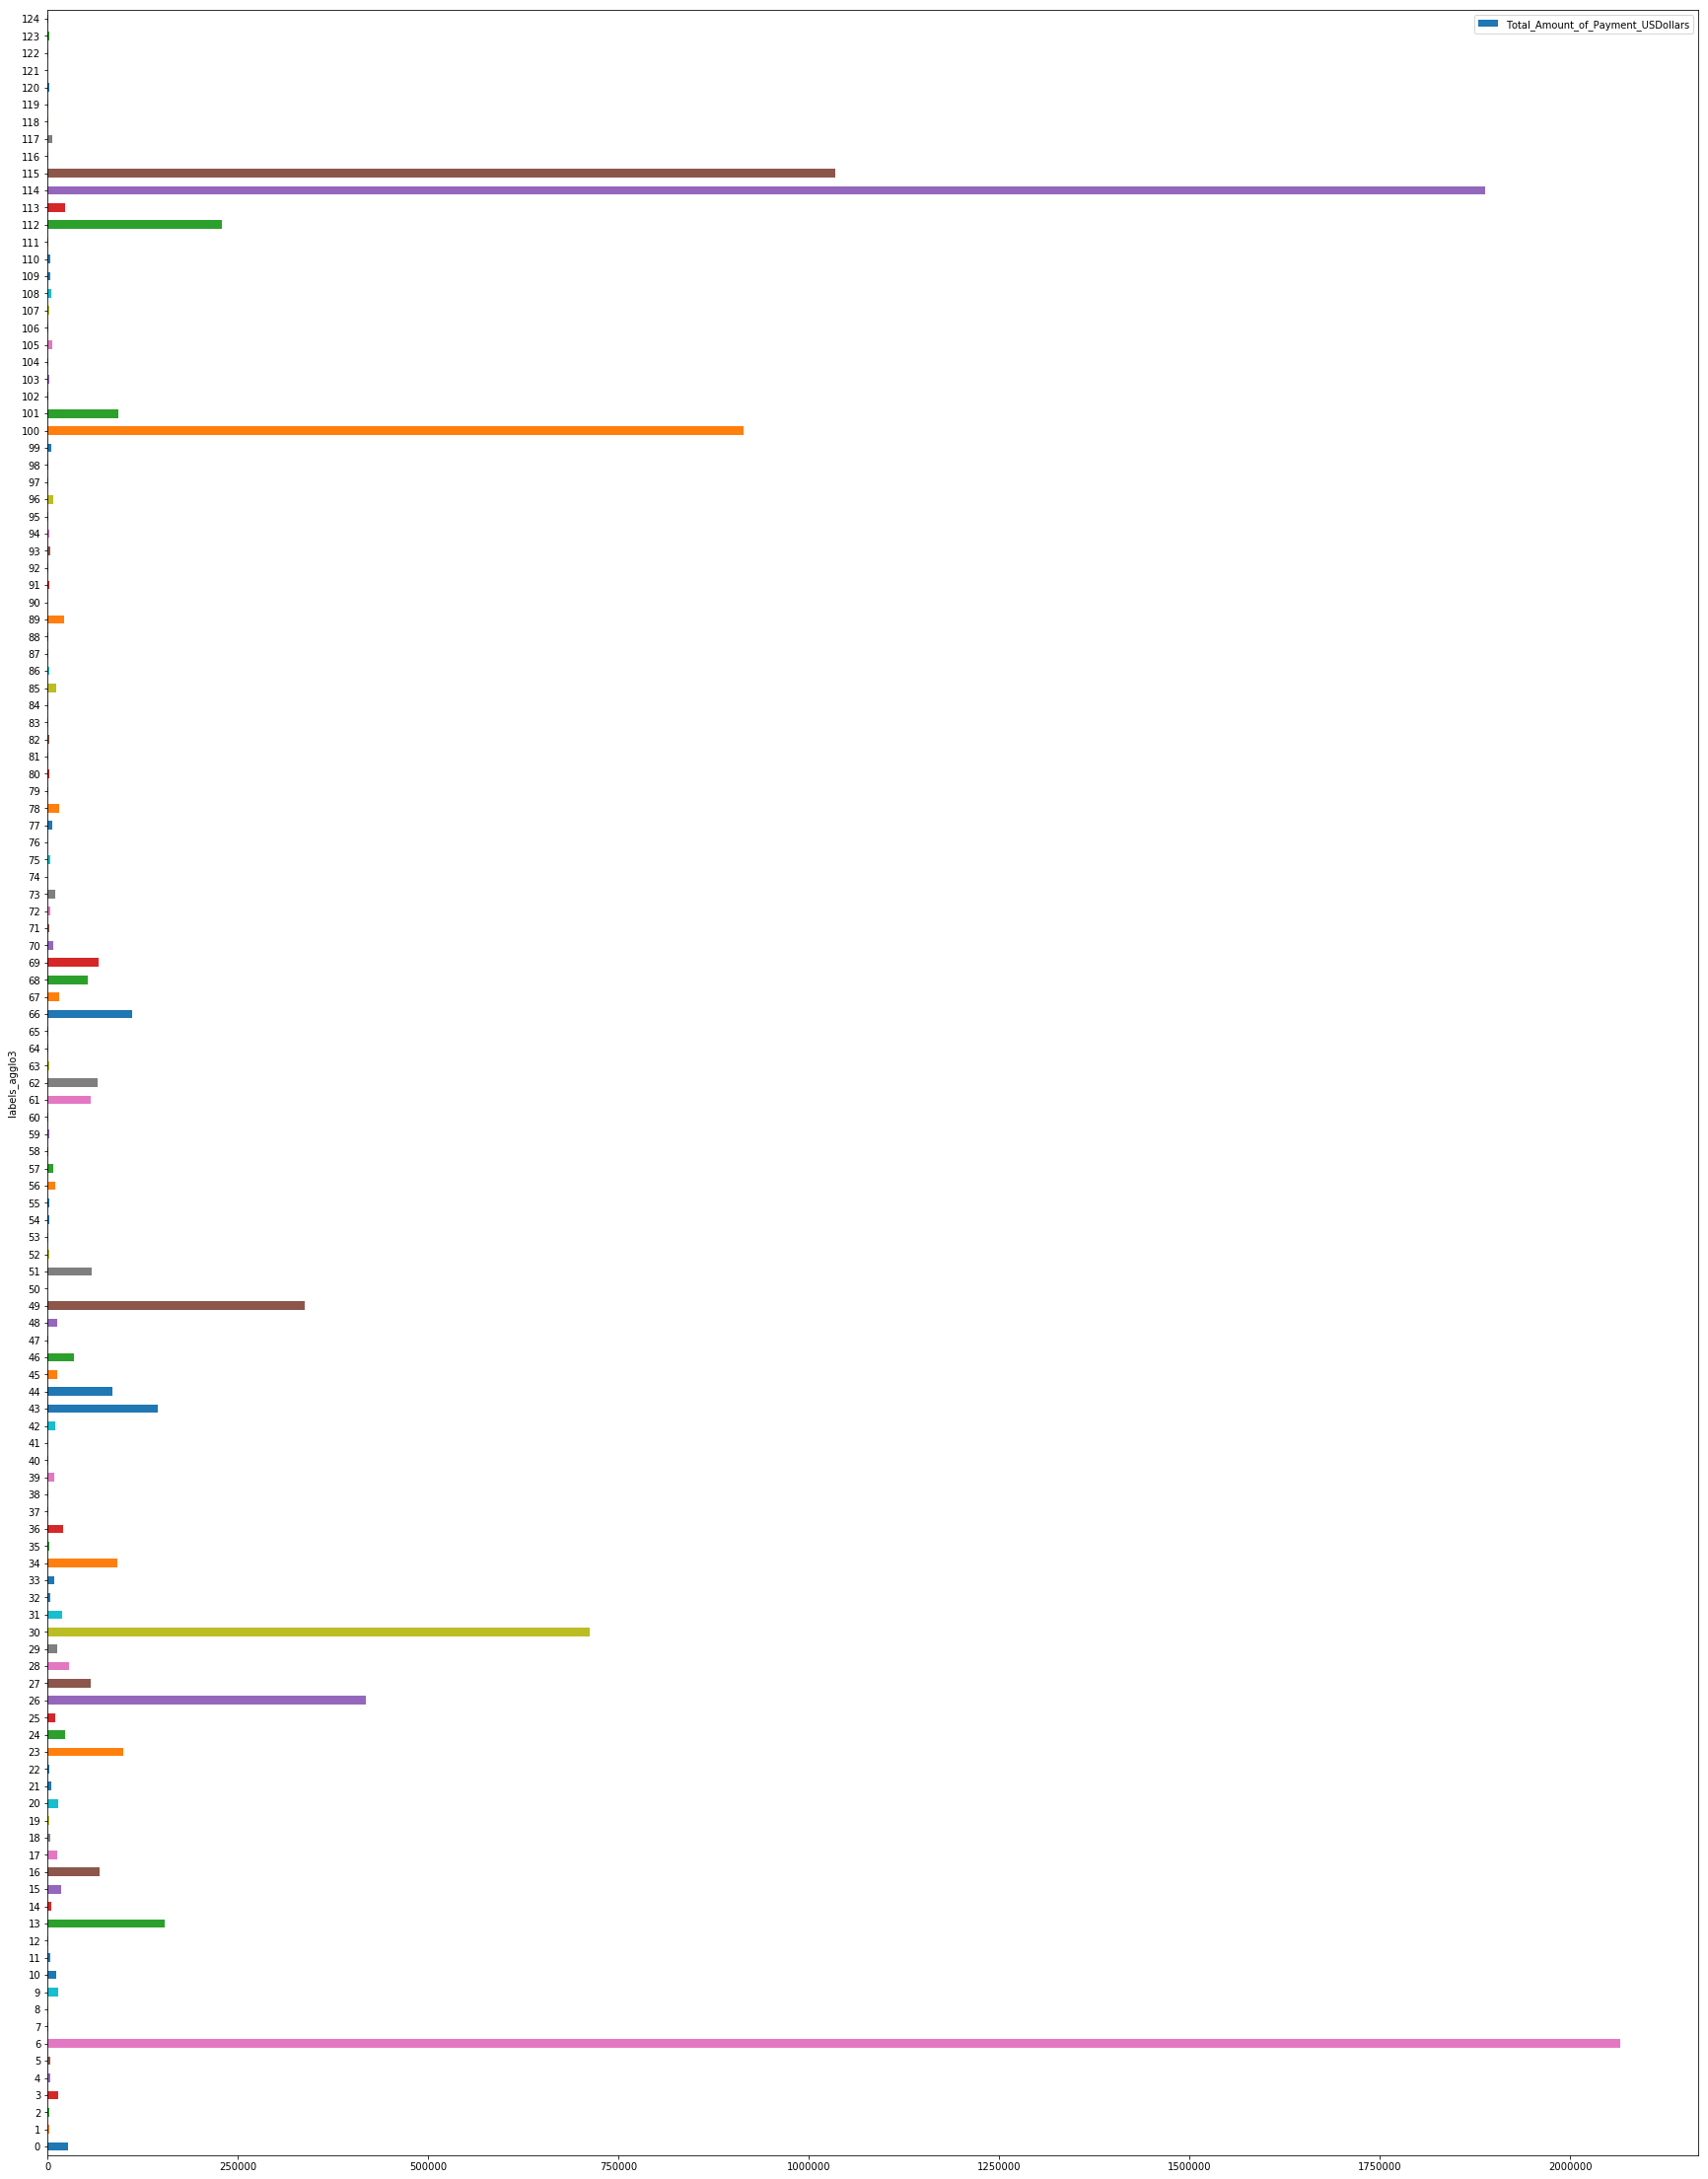

In [17]:

plt.figure(figsize=(30,40))
general_payments_clus.groupby('labels_agglo3')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

In [18]:
general_payments_clus

,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Province,Physician_Primary_Type,Physician_Specialty,...,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Number_of_Payments_Included_in_Total_Amount,Nature_of_Payment_or_Transfer_of_Value,Physician_Ownership_Indicator,Charity_Indicator,Record_ID,Program_Year,labels_agglo3
0,148369,JOHN,M,ZAJECKA,CHICAGO,IL,60612,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Psychiatry...,...,IN,United States,131.04,1,Travel and Lodging,No,No,100171622,2013,26
1,301766,BRANDY,R,MATTHEWS,INDIANAPOLIS,IN,46202,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Psychiatry...,...,IN,United States,2.99,1,Food and Beverage,No,No,100172478,2013,23
2,39552,ANTHONY,A,GASPARI,BALTIMORE,MD,21201,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Dermatology,...,IN,United States,2.99,1,Food and Beverage,No,No,100172484,2013,26
3,437390,XIAOLIN,CHARLIE,WU,INDIANAPOLIS,IN,46202,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Pathology|...,...,IN,United States,177.00,1,Travel and Lodging,No,No,100172506,2013,23
4,41273,MANU,V,CHAKRAVARTHY,NEW BRUNSWICK,NJ,8901,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,80.50,1,Travel and Lodging,No,No,100172522,2013,26
5,211520,JOHN,J,BUDD,SAINT LOUIS,MO,63117,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,138.04,1,Travel and Lodging,No,No,100170982,2013,34
6,249600,DANIEL,J,CLAUW,ANN ARBOR,MI,48109,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,110.58,1,Travel and Lodging,No,No,100171006,2013,34
7,326708,RICHARD,W,MARTIN,GRAND RAPIDS,MI,49546,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,138.04,1,Travel and Lodging,No,No,100171662,2013,34
8,293579,CRAIG,L,LEONARDI,SAINT LOUIS,MO,63117,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Dermatology,...,IN,United States,173.80,1,Travel and Lodging,No,No,100170066,2013,34
9,96207,GILBERT,R,WEINER,HOLLYWOOD,FL,33021,NaN,Doctor of Osteopathy,Allopathic & Osteopathic Physicians|Family Med...,...,IN,United States,253.00,1,Travel and Lodging,No,No,100171688,2013,34


In [22]:
x=general_payments_clus.groupby('labels_agglo3')['Total_Amount_of_Payment_USDollars'].sum()/general_payments_clus.groupby('labels_agglo3')['Physician_Profile_ID'].nunique()

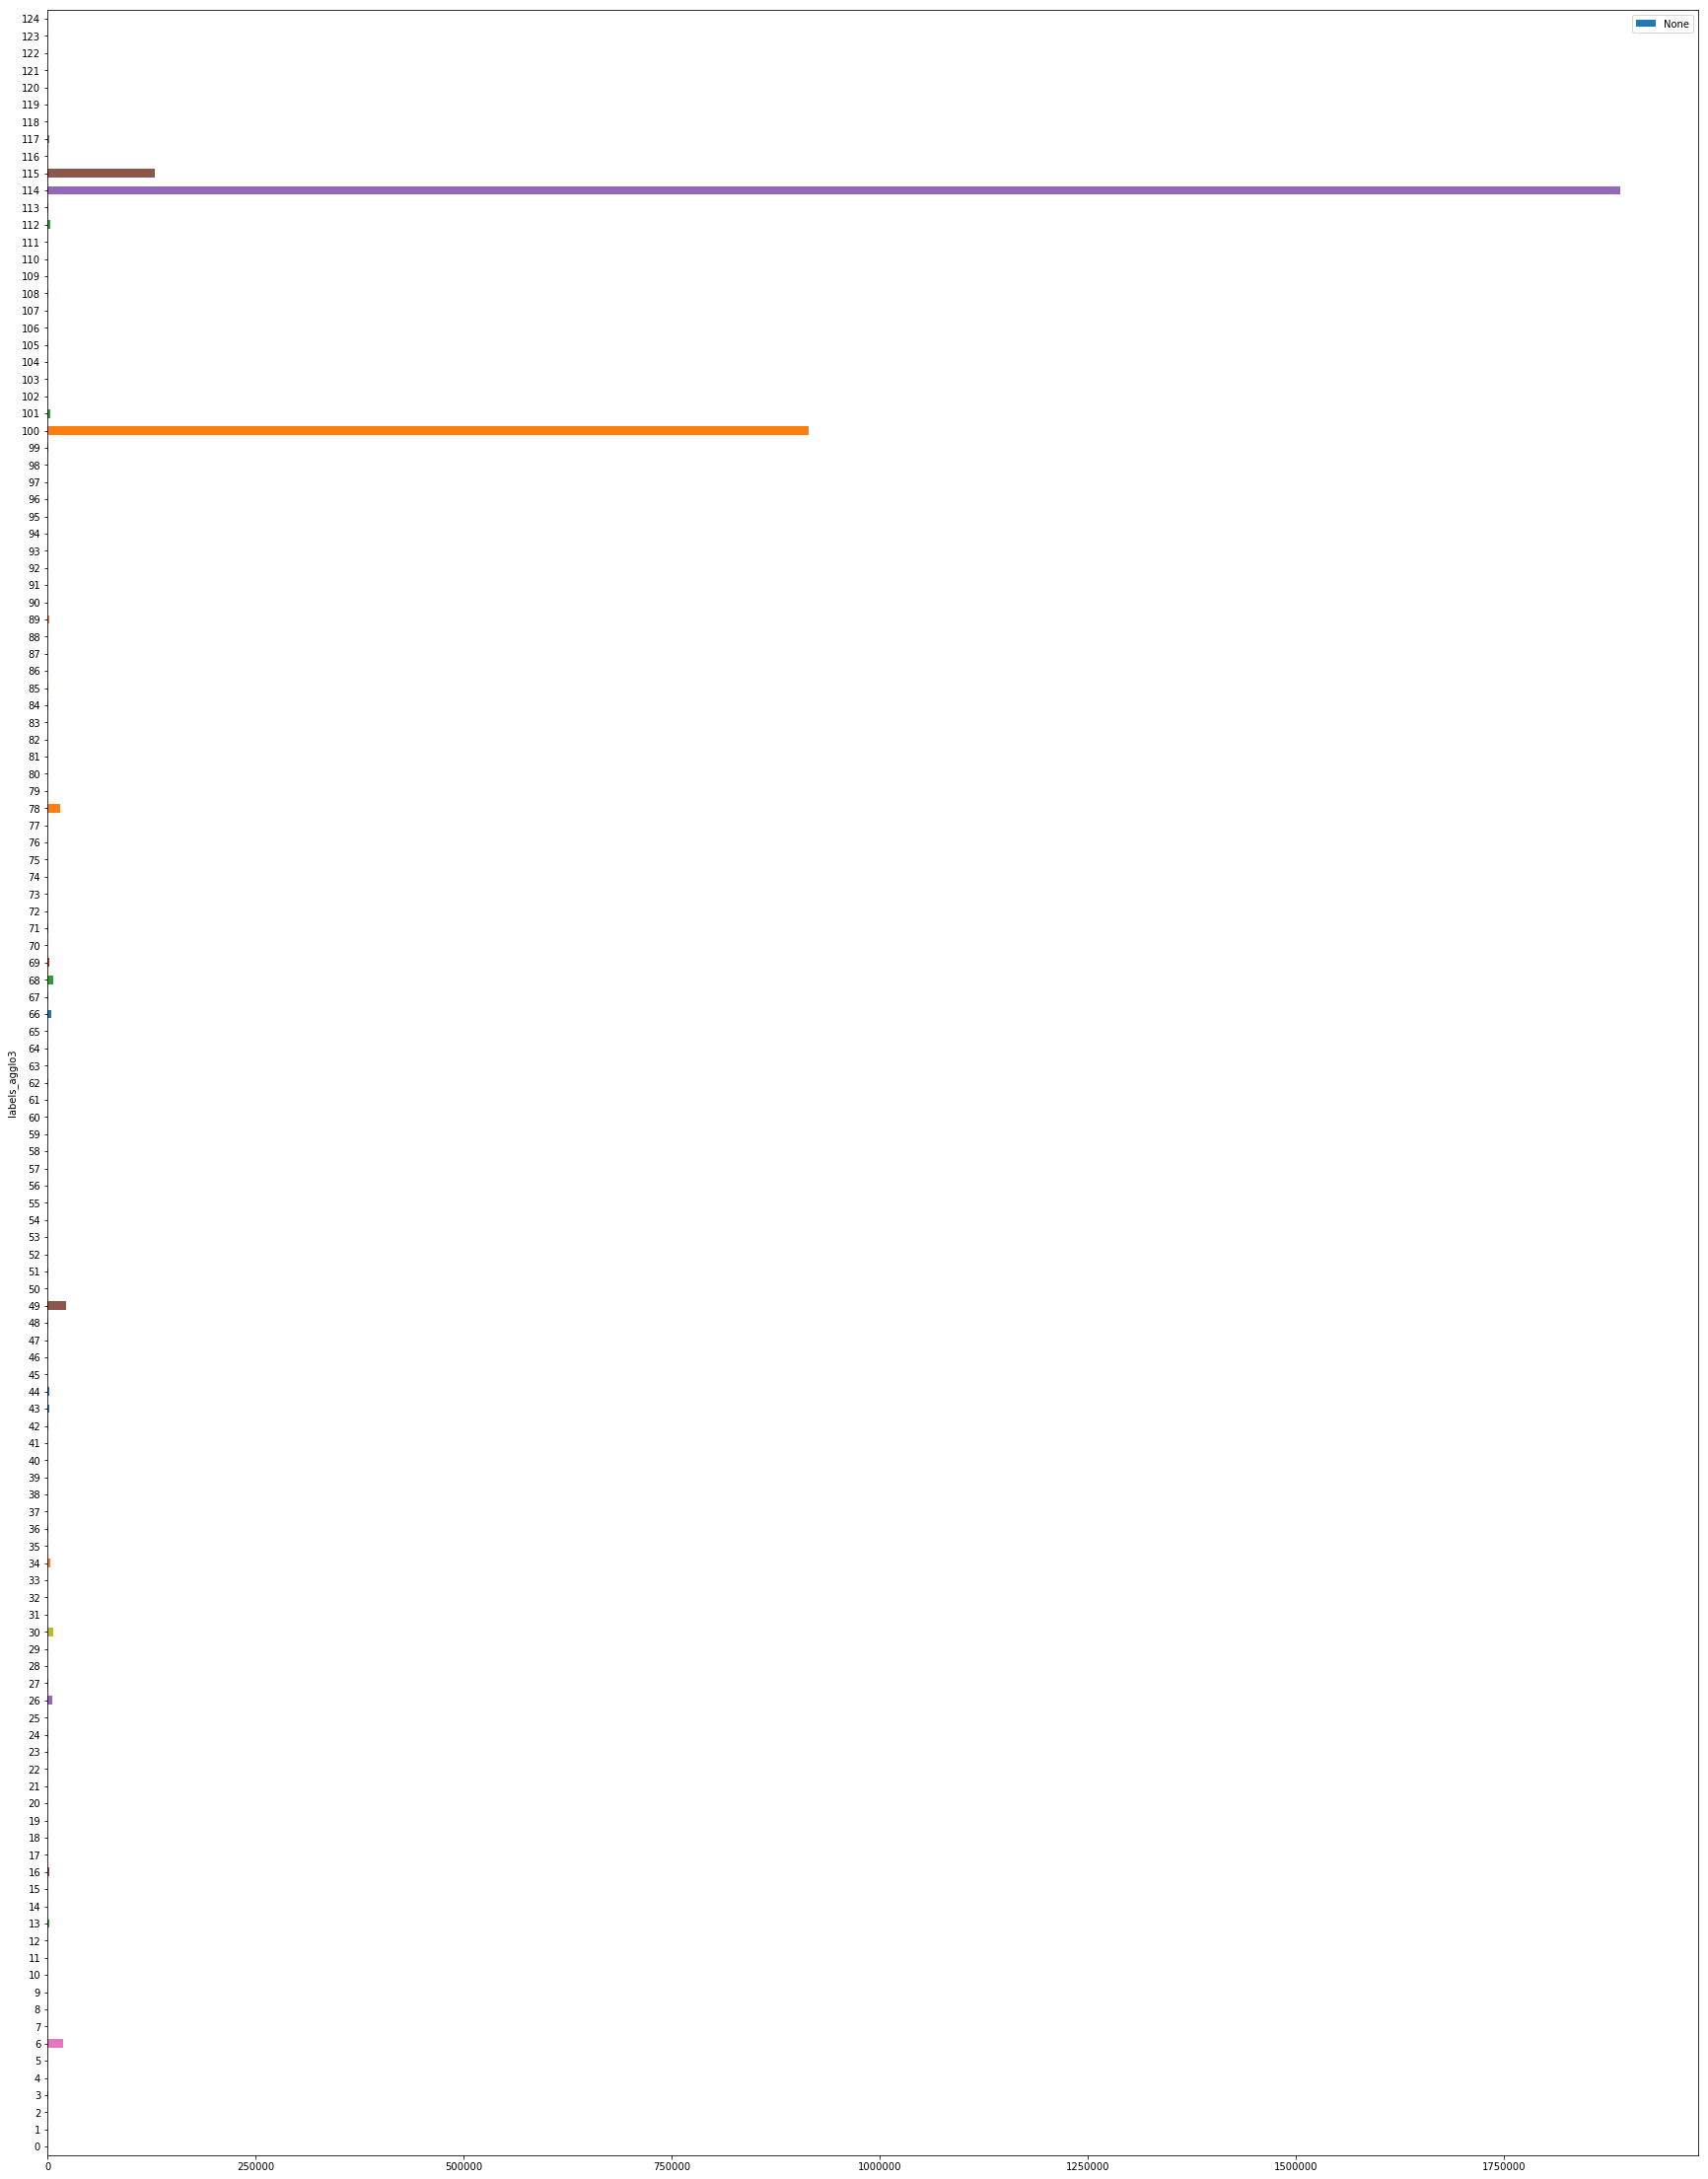

In [24]:
plt.figure(figsize=(30,40))

x.plot(kind='barh',legend=True)

In [61]:
df=general_payments_clus[general_payments_clus['labels_agglo3'].isin([114,115,100,78,49])]



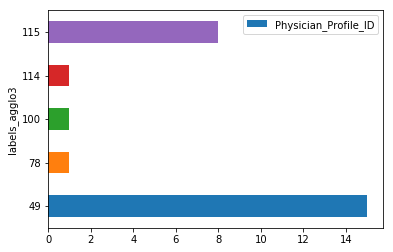

In [62]:

%matplotlib inline
df.groupby('labels_agglo3')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)

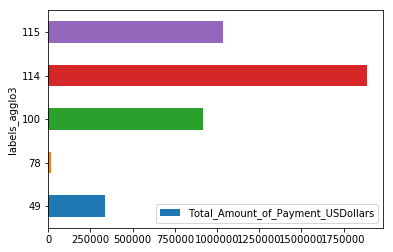

In [63]:

%matplotlib inline
df.groupby('labels_agglo3')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

In [70]:
df2=df.drop_duplicates(subset=['Physician_Profile_ID'])
df2


,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Province,Physician_Primary_Type,Physician_Specialty,...,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Number_of_Payments_Included_in_Total_Amount,Nature_of_Payment_or_Transfer_of_Value,Physician_Ownership_Indicator,Charity_Indicator,Record_ID,Program_Year,labels_agglo3
19,1158450,BLAINE,W,FARLEY,INDIANAPOLIS,IN,46219,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Emergency ...,...,IN,United States,31740.00,1,Compensation for services other than consultin...,No,No,100011666,2013,115
22,150155,ROBERT,A,STRAWBRIDGE,INDIANAPOLIS,IN,46260,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,23512.50,1,Compensation for services other than consultin...,No,No,100011688,2013,115
25,225339,JOHN,A,SPERTUS,KANSAS CITY,MO,64111,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,60013.00,1,Compensation for services other than consultin...,No,No,100011788,2013,115
26,293260,JOEL,M,KREMER,ALBANY,NY,12206,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,68851.64,1,Compensation for services other than consultin...,No,No,100011790,2013,115
85,202285,EMERY,C,POLASEK,KALAMAZOO,MI,49008,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,...,IN,United States,11000.00,1,Compensation for services other than consultin...,No,No,100011690,2013,115
100,16094,MICHAEL,WALTER,WEINER,SAN FRANCISCO,CA,94121,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,266.22,1,Travel and Lodging,No,No,100170878,2013,115
171,211354,DAVID,B,KAUFMAN,BRONX,NY,10463,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,12264.00,1,Consulting Fee,No,No,100179772,2013,78
276,56427,JOHNNIE,NaN,AYERS,INDIANAPOLIS,IN,46227,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Emergency ...,...,IN,United States,35325.00,1,Compensation for services other than consultin...,No,No,100011660,2013,115
466,785575,JUNKO,NaN,TAKESHITA,PHILADELPHIA,PA,19104,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,...,IN,United States,20000.00,1,Compensation for services other than consultin...,No,No,100011634,2013,115
11585,220511,STEVE,T,CHARLES,MEMPHIS,TN,38119-4810,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Ophthalmology,...,NaN,Switzerland,269578.91,1,Royalty or License,No,No,234202792,2015,100


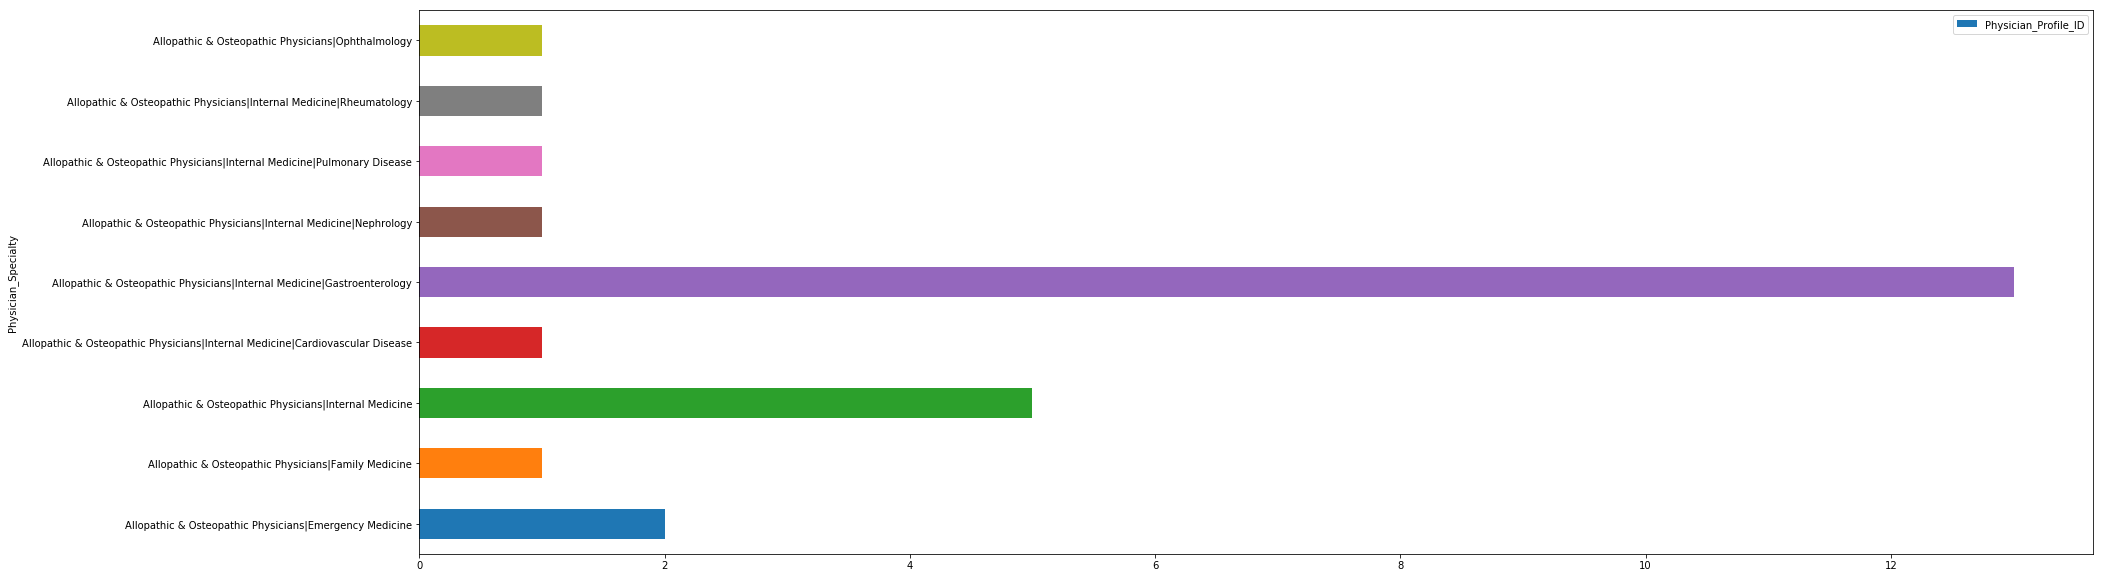

In [71]:
plt.figure(figsize=(30,10))

df2.groupby('Physician_Specialty')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)

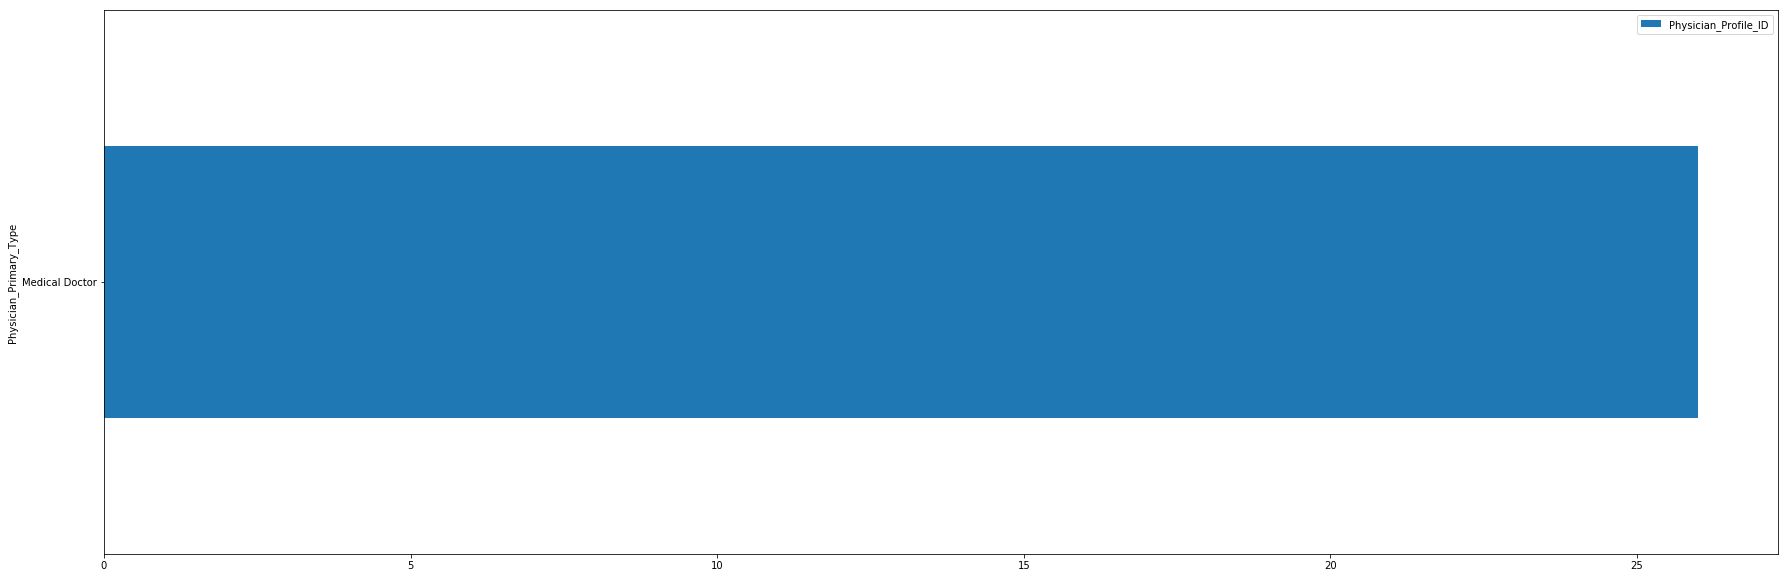

In [72]:
plt.figure(figsize=(30,10))

df2.groupby('Physician_Primary_Type')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)

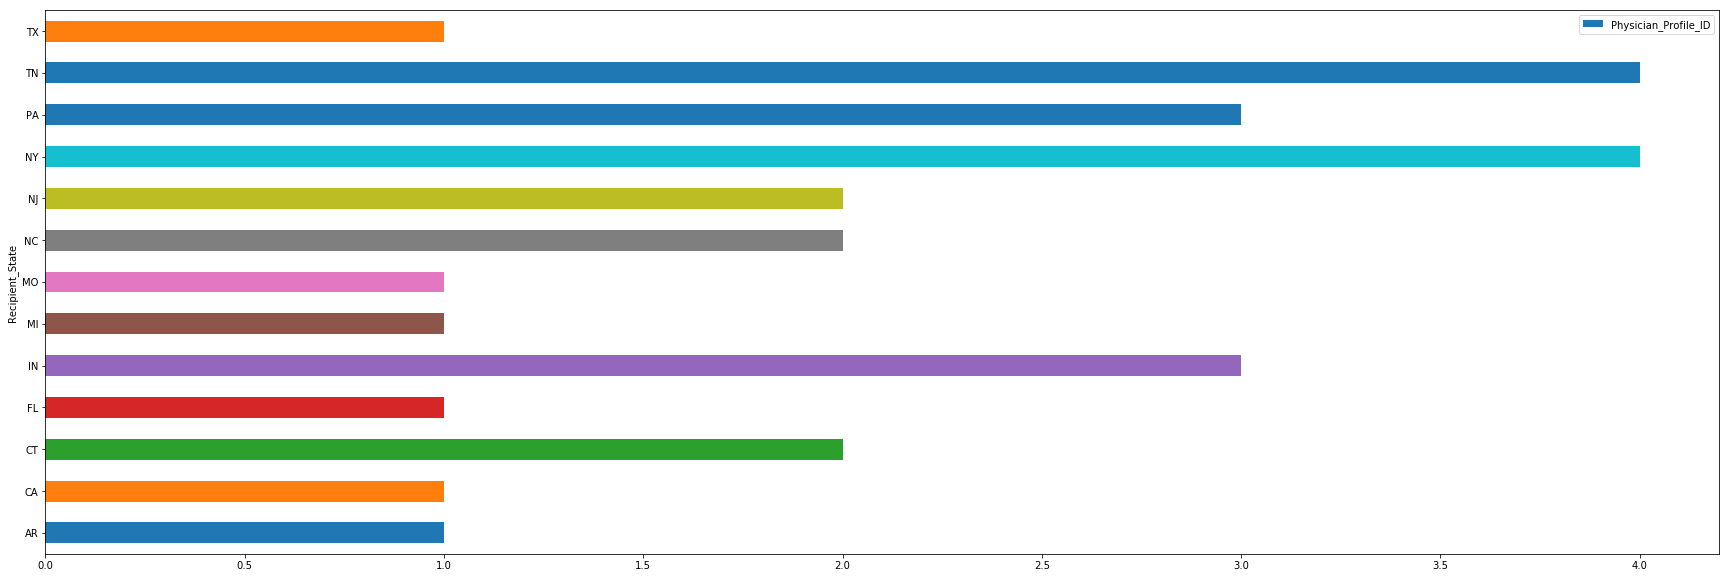

In [73]:
plt.figure(figsize=(30,10))

df2.groupby('Recipient_State')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)

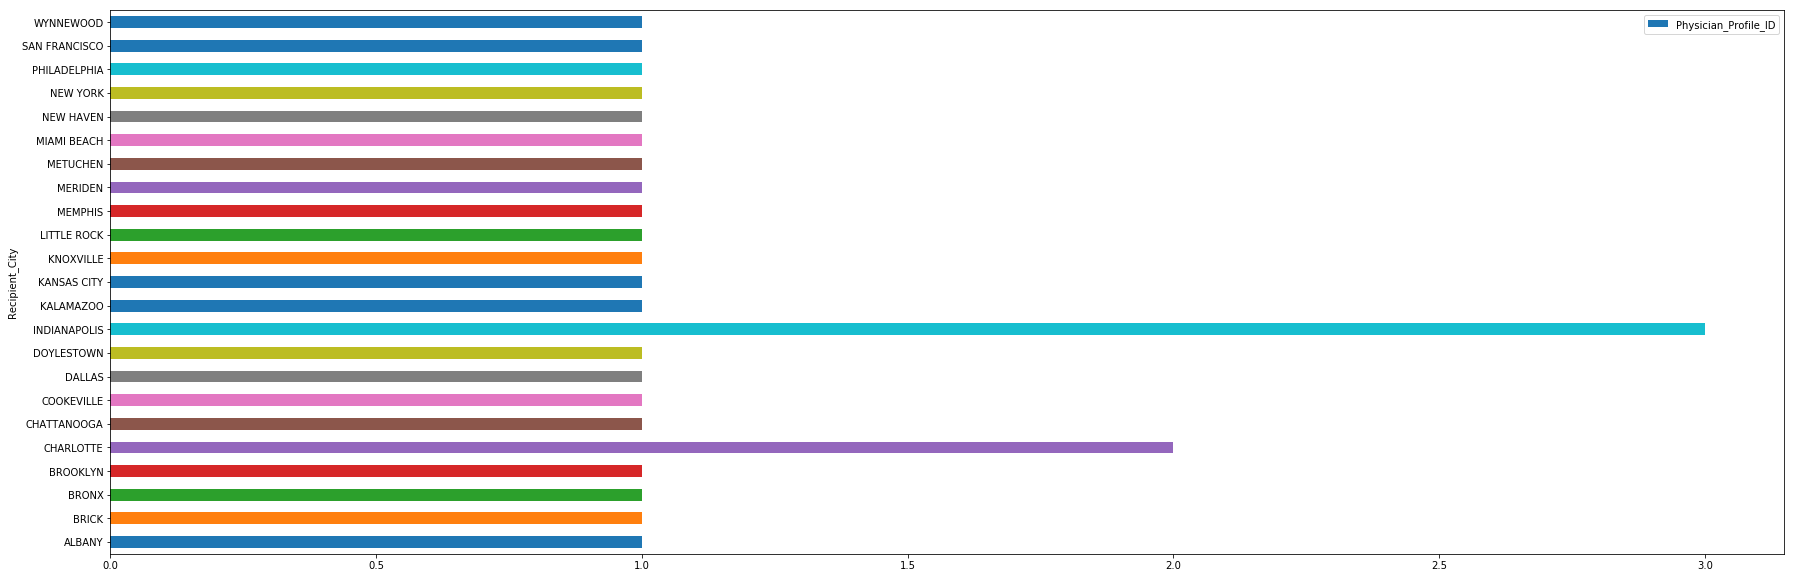

In [74]:
plt.figure(figsize=(30,10))

df2.groupby('Recipient_City')['Physician_Profile_ID'].nunique().plot(kind='barh',legend=True)

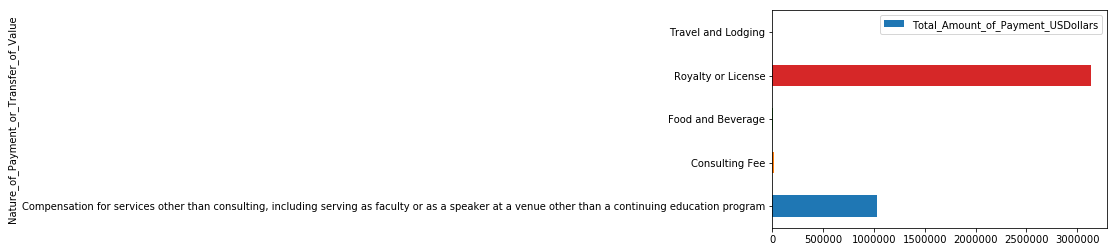

In [75]:

df.groupby('Nature_of_Payment_or_Transfer_of_Value')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)

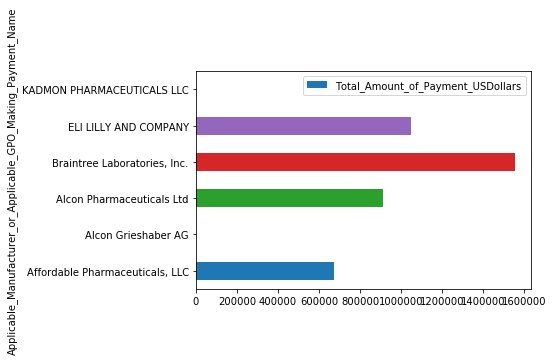

In [76]:
df.groupby('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh',legend=True)